# Inversion problem on Hilbert Model space

In [18]:
import numpy as np
from pygeoinf import linalg, forward_problem, optimisation
import scipy.integrate as spi
from scipy.special import legendre
from sola.main_classes import functions, domains
from sola.aux import predefined_functions
import matplotlib.pyplot as plt

## Define spaces and mappings

### Define D and and measure on D

In [19]:
# Define the data space
D_dim = 5
D = linalg.EuclideanSpace(D_dim)

# Define the Data gaussian measures
C_D = np.eye(D_dim)
d_tilde = D.zero
mu_D = linalg.GaussianMeasure(D, C_D, expectation=d_tilde)

### Define M

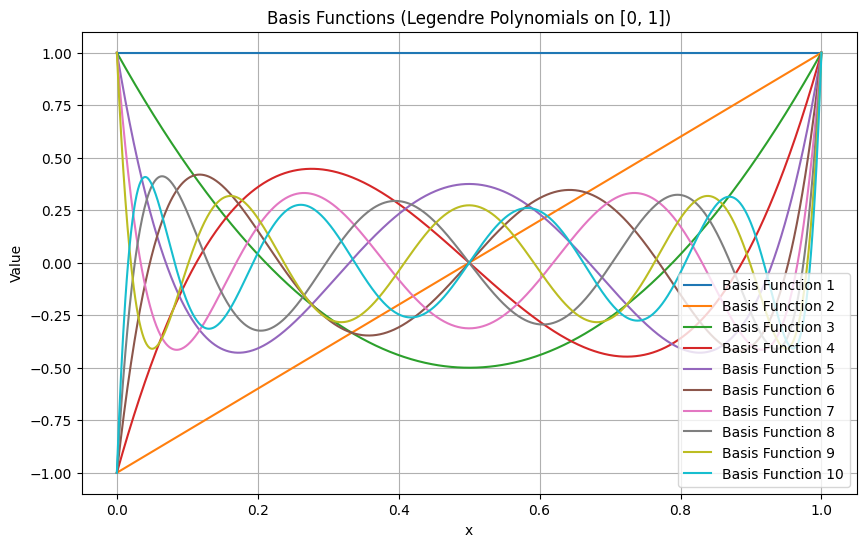

In [20]:
%matplotlib inline
# Define Model space

# Discretization of the model space
M_dim = 10

# Define the basis functions (Legendre polynomials on [0,1])
domain = domains.HyperParalelipiped([[0, 1]])
basis_functions_evaluation = [
    lambda x, n=n: legendre(n)(2 * x - 1)
    for n in range(M_dim)
]
basis_functions = [
    functions.Function(
        domain,
        evaluate_callable=basis_function
    )
    for basis_function in basis_functions_evaluation
]

# Plot the basis functions

# Evaluate each basis function on the domain
plt.figure(figsize=(10, 6))
for i, basis_function in enumerate(basis_functions):
    plt.plot(domain.mesh, basis_function.evaluate(domain.mesh), label=f"Basis Function {i+1}")

# Add labels, title, and legend
plt.title("Basis Functions (Legendre Polynomials on [0, 1])")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [21]:
# Define the inner product on the model space
def M_inner_product(f: functions.Function, g: functions.Function):
    return spi.quad(
        lambda x: f.evaluate(x) * g.evaluate(x),
        f.domain.bounds[0][0],
        f.domain.bounds[0][1]
    )[0]

# Convert function to coefficients (projection onto basis)
def M_to_components(f: functions.Function, basis_functions):
    return [
        M_inner_product(f, basis_function)
        for basis_function in basis_functions
    ]

# Convert coefficients back to function (linear combination)
def M_from_components(c, M_dim):
    function_evaluation = lambda x: sum(
        c[i] * basis_functions[i].evaluate(x)
        for i in range(M_dim)
    )
    return functions.Function(
        domain,
        evaluate_callable=function_evaluation
    )

M = linalg.HilbertSpace(M_dim, lambda f: M_to_components(f, basis_functions),
                        lambda c: M_from_components(c, M_dim),
                        M_inner_product)

### Define G

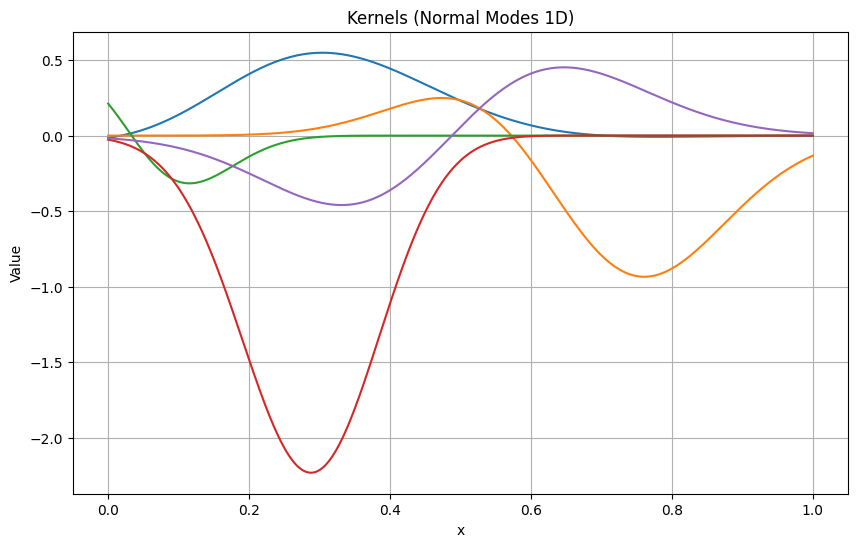

In [22]:
# Define G mapping
kernels = [
    predefined_functions.NormalModes_1D(
        domain, order=10, spread=0.1, max_freq=10
    ) for _ in range(D_dim)
]

# Plot all the kernels
plt.figure(figsize=(10, 6))

for i, kernel in enumerate(kernels):
    y = kernel.evaluate(domain.mesh)  # Evaluate the kernel on the domain's mesh
    plt.plot(domain.mesh, y, label=f"Kernel {i+1}")

# Add labels, title, and legend
plt.title("Kernels (Normal Modes 1D)")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.show()

In [23]:
# Define the G mapping function
# This function maps a function `f` in the model space to a vector in the data space
# by computing the inner product of `f` with each kernel in the `kernels` list.
def G_mapping(f: functions.Function, kernels):
    return np.array([M.inner_product(f, kernel) for kernel in kernels])

# Define the linear operator G
# This operator maps from the model space (M) to the data space (D) using the G_mapping function.
G = linalg.LinearOperator(M, D, lambda f: G_mapping(f, kernels))

## Form the Inverse Problem

In [26]:
problem = forward_problem.ForwardProblem(G, mu_D)
inversion_problem = optimisation.LeastSquaresInversion(G, mu_D)

In [28]:
# Compute the normal operator
inversion_problem.normal_operator(1)